In [1]:
import bs4
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import *
import re
import pandas as pd
import datetime
import time

### <b>Step 1a: Use selenium's webdriver to get elevatemaps content</b>
The elevatemaps site requires you to login before accessing property data so you must simulate a web browser with Selenium and login to the site by programming commands to click the login button and enter a username and password

In [2]:
url = 'https://monroein.elevatemaps.io/#extent=3263633.3333333335,2971966.6666666665,1497244.0972222222,1362955.9027777778,2245'

firefox_options = Options()
#firefox_options.add_argument("--headless") # COMMENT / UNCOMMENT THIS IF YOU WANT TO SEE WHAT IS HAPPENING IN THE SIMULATED BROWSER
driver = webdriver.Firefox(options=firefox_options, executable_path="geckodriver.exe")

driver.get(url)

login_with_email_button = WebDriverWait(driver, 3).until(EC.element_to_be_clickable((By.XPATH, "/html/body/div[6]/div/div[2]/div[2]/div[2]/div[3]/div[5]")))
login_with_email_button.click()

email_form = driver.find_element_by_xpath('/html/body/div[6]/div/div[2]/div[2]/div[2]/div[4]/div[2]/input[1]')
email_form.send_keys("nacs16@gmail.com")

password_form = driver.find_element_by_xpath('/html/body/div[6]/div/div[2]/div[2]/div[2]/div[4]/div[2]/input[2]')
password_form.send_keys("R4z7Ch2&xEGjaoVmu4yV")

sign_in_button = driver.find_element_by_xpath('/html/body/div[6]/div/div[2]/div[2]/div[2]/div[4]/div[3]')
sign_in_button.click()

licence_agreement_accept_button = WebDriverWait(driver, 3).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="dijit_form_Button_79"]')))
licence_agreement_accept_button.click()

### <b>Step 1b: After logging in, you may now access property data by inputing the property parcel number in the url</b>


In [3]:
baseurl = "https://monroein.elevatemaps.io/prc.html?pin={}&appId=56a2422e6debad32771174b3"
parcel_no = "53-08-01-203-009.000-009"
url = baseurl.format(parcel_no)

# Tell the webdriver to navigate to the URL for the given parcel number
driver.get(url)

# wait until the content is loaded by checking the page element where the parcel number is printed
WebDriverWait(driver, 5).until(EC.text_to_be_present_in_element((By.XPATH, "/html/body/div[4]/div[1]/div[3]/div/div/div[1]/div[1]/div[3]/div[2]/div[3]/div[2]"), parcel_no))

# convert the driver page source to html
html = driver.page_source

# open a BeautifulSoup object with the html
bs = BeautifulSoup(html)

In [4]:
# Find and print the property info elements on the page
for e in bs.find_all(class_="FormChild", attrs={"data-dojo-attach-point": [e.get_attribute("data-dojo-attach-point") for e in driver.find_elements_by_class_name("FormChild.PIValueLabel")]}):
    print(e.attrs["data-dojo-attach-point"], " ", e.text)

ownerNamePRC   Coleman, Patricia A
ownerAddressPRC   4015 E Stonegate Ct Bloomington, In 47401
parcelNumber   53-08-01-203-009.000-009
altParcelNumber   015-13540-04
propAddress   4015 E Stonegate Ct, Bloomington, In 47401
propClassCode   510
propClass   1 Family Dwell - Platted Lot
neighborhood   Stonegate Village - V, 53009121-009
legalDescription1   015-13540-04 STONEGATE VILLAGE LOT 15
township   Perry Township
corporation   Monroe County Community
taxingDistrict   Bloomington City-perry Townshi
taxingDistrictNumber   009
water   N
sewer   N
gas   N
electricity   N
all   Y
bedRooms   3
finishedRooms   4
fullBaths   3
fullBathsFixtures   9
halfBaths   
halfBathsFixtures   
kitchenSinks   1
heatType   Central Warm Air
fireplaces   1
attachedGarages   400
parcelNumberTax   53-08-01-203-009.000-009
taxId   015-13540-04
ownerName   Coleman, Patricia A
ownerAddress   4015 E Stonegate Ct Bloomington, In 47401
legalDescription   015-13540-04 STONEGATE VILLAGE LOT 15
ov1pin   53-08-01-203-0

In [174]:
# Put all these steps into a standalone function

from selenium.common.exceptions import *
import numpy as np

def get_property_data(driver, parcel_no):
    baseurl = "https://monroein.elevatemaps.io/prc.html?pin={}&appId=56a2422e6debad32771174b3"
    url = baseurl.format(parcel_no)
    driver.get(url)
    try:
        WebDriverWait(driver, 15).until(EC.text_to_be_present_in_element((By.XPATH, "/html/body/div[4]/div[1]/div[3]/div/div/div[1]/div[1]/div[3]/div[2]/div[3]/div[2]"), parcel_no))
    except TimeoutException as e:
        return False
    html = driver.page_source
    bs = BeautifulSoup(html)
    row = {}
    for e in bs.find_all(class_="FormChild", attrs={"data-dojo-attach-point": [e.get_attribute("data-dojo-attach-point") for e in driver.find_elements_by_class_name("FormChild.PIValueLabel")]}):
        row[e.attrs["data-dojo-attach-point"]] = e.text
        #print(e.attrs["data-dojo-attach-point"], " ", e.text)
    
    row['image_links'] = [child_element.attrs['src'] for child_element in bs.find_all(class_="PIThumbnailContainer", attrs={"data-dojo-attach-point": "thumbnailsDiv"})[0].children]
    
    try:
        e = bs.find_all(attrs={"data-dojo-attach-point": "floorsGridDiv"})[0]
    except IndexError as error:
        row['floors'] = np.nan
        return row
    for grid_section in [element for element in list(e.descendants) if type(element) != bs4.element.NavigableString and "data-dojo-attach-point" in element.attrs]:
        if grid_section.attrs["data-dojo-attach-point"] == 'header':
            headers = [element.text for element in grid_section.descendants if type(element) != bs4.element.NavigableString]
        else:
            content = np.array([element.text for element in grid_section.descendants if type(element) != bs4.element.NavigableString and element.attrs["class"] == ['InlineChild', 'SimpleGridCellLabel']])
            content = content.reshape(int(len(content)/len(headers)), (len(headers)))
    d = {}
    for i, header in enumerate(headers):
        d[header] = [row[i] for row in content]
    row['floors'] = d    
    
    return row

In [ ]:
labels = [e.text.strip() for e in driver.find_elements_by_class_name("FormChild.PIPropertyLabel") if e.text.strip() != ""]
values = [e.text.strip() for e in driver.find_elements_by_class_name("FormChild.PIValueLabel") if e.text.strip() != ""]
#print(len(labels), len(values))

for label, value in zip(labels, values):
    print(label, ": ", value)

In [183]:
test_row = get_property_data(driver, "53-08-06-106-001.000-008")

In [ ]:
test_row

In [158]:
e = bs.find_all(attrs={"data-dojo-attach-point": "floorsGridDiv"})[0]
for grid_section in [element for element in list(e.descendants) if type(element) != bs4.element.NavigableString and "data-dojo-attach-point" in element.attrs]:
    if grid_section.attrs["data-dojo-attach-point"] == 'header':
        headers = [element.text for element in grid_section.descendants if type(element) != bs4.element.NavigableString]
    else:
        content = np.array([element.text for element in grid_section.descendants if type(element) != bs4.element.NavigableString and element.attrs["class"] == ['InlineChild', 'SimpleGridCellLabel']])
        content = content.reshape(int(len(content)/len(headers)), (len(headers)))
    

In [ ]:
# List of indiana parcel numbers can be downloaded here: https://gateway.ifionline.org/public/download.aspx
# Under Propery Files, select Real Property and download
# But the formatting of the downlaoded file is awful so we'll loop through the text lines and take out just the parcel numbers.

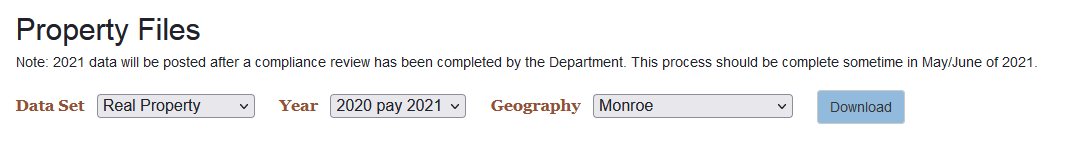

### Getting a list of Monroe County property parcel numbers

In [170]:
# Example parcel number format for the elevatemaps.io URL: 53-08-01-203-009.000-009
line_number = 0
limit = 100000
parcel_numbers = []
with open('RealParcel_Monroe_53_2020P2021.txt', 'r') as txt_file:
    for L in txt_file:
        if line_number > 0:
            parcel_number = L[0:2]+"-"+L[2:4]+"-"+L[4:6]+"-"+L[6:9]+"-"+L[9:12]+"."+L[12:15]+"-"+L[15:18]
            parcel_numbers.append(parcel_number)
        line_number+=1
        if line_number > limit:
            break

In [171]:
len(parcel_numbers)

55219

In [172]:
parcel_numbers = pd.Series(parcel_numbers)

### <b>Step 2: Assemble a dataframe of property attributes scraped from the page</b>

In [ ]:
#property_info = []
for parcel_no in parcel_numbers:#.sample(n=100):
    if parcel_no in property_info_df.parcelNumber:
        continue
    try:
        data = get_property_data(driver, parcel_no)
    except:
        raise Exception("Error on parcel no: ", parcel_no)
    if data is not False:
        property_info.append(data)
print("DONE")

In [186]:
property_info_df = pd.DataFrame(property_info)

In [ ]:
property_info_df.drop_duplicates("parcel_no")

In [193]:
property_info_df

,ownerNamePRC,ownerAddressPRC,parcelNumber,altParcelNumber,propAddress,propClassCode,propClass,neighborhood,legalDescription1,township,...,fullBathsFixtures,halfBaths,halfBathsFixtures,kitchenSinks,heatType,fireplaces,attachedGarages,commFixtures,commExtraFixtures,waterCoolerRefrig
0,City Of Bloomington,"Po Box 100 Bloomington, In 47402",53-08-02-200-016.000-009,015-90150-00,"S College Mall Rd, Bloomington, In 47401",640,"Exempt, Municipality","48A Pc - College Mall Area - Com - A, 53009187...",015-90150-00 PT W1/2 NW 2-8-1W .03A,Perry Township,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,City Of Bloomington,"Po Box 100 Bloomington, In 47402",53-08-02-200-025.000-009,015-91160-00,"S College Mall Rd, Bloomington, In 47401",640,"Exempt, Municipality","48A Pc - College Mall Area - Com - A, 53009187...",015-91160-00 PT W1/2 NW 2-8-1W .036A,Perry Township,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Dept. Of Conservation,Division Of Forestry 402 W Washington St W296 ...,53-06-15-100-012.000-003,003-27660-00,"N Mccoy Rd, Bloomington, In 47408",610,"Exempt, State Of Indiana","Benton - Compliant, 53003999-003",003-27660-00 NE NE 15-9-1E 40.00A,Benton Township,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Dept. Of Conservation,Division Of Forestry 402 W Washington St W296 ...,53-06-15-400-001.000-003,003-28200-00,"E Baby Creek Rd, Bloomington, In 47408",610,"Exempt, State Of Indiana","Benton - Compliant, 53003999-003",003-28200-00 PT SE SE 15-9-1E 3.75A,Benton Township,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Board Of Commissioners Of Monroe Co,"Courthouse Bloomington, In 47404",53-08-02-200-037.000-009,015-90060-00,"S College Mall Rd, Bloomington, In 47401",620,"Exempt, County","Perry City - Compliant, 53009999-009",015-90060-00 PT NW NW 2-8-1W 1.00A; PT OF COLL...,Perry Township,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61234,"D'amico, William M.","9235 Old County Rd Ben Lomond, Ca 95005-9249",53-05-32-113-016.000-005,013-16440-00,"708 W 11th St, Bloomington, In 47404",419,Other Commercial Housing,"1311 Trending 2006 - A, 53005060-005",MAPLE HEIGHTS LOT 14,Bloomington Township,...,3,,,1,Central Warm Air,,,NaN,NaN,NaN
61235,"Minch, Jill E","2015 W Arlington Rd Bloomington, In 47404",53-05-29-302-002.000-005,013-16445-00,"2015 W Arlington Rd, Bloomington, In 47404-1501",510,1 Family Dwell - Platted Lot,"Arlington Place - A, 53005024-005",013-16445-00 WARDS LOT 4,Bloomington Township,...,3,,,1,Central Warm Air,,,NaN,NaN,NaN
61236,One Pair Of Deuces Llc,"1292 S Cobble Creek Cir Bloomington, In 47401",53-05-33-310-286.000-005,013-21830-00,"122 S College Ave, Bloomington, In 47404-5165",429,Other Retail Structures,"38 Bloomington City - Downtown - Com, 53005076...",ORIGINAL PLAT PT LOT 87,Bloomington Township,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
61237,Connie Llc,"8680 W Vernal Pike Bloomington, In 47404",53-04-33-300-003.000-011,007-22900-01,"W Vernal Pike, Bloomington, In 47404",599,Other Residential Structures,"Vernal Pike - Rt2 - A, 53011029-011",PT E1/2 SW 33-9-2W 20A PLAT 7,Richland Township,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
property_info_df.drop_duplicates("parcelNumber").to_csv("property_info.csv", index=False)

### <b>Step 3: Download or Save Links to Pictures</b>

In [ ]:
#Vectorize pictures or save the picture url

Notes:

State of Indiana 18 Digit Parcel Numbers
By Ken Blaudow
Mortgage and Lending with Indy Mortgage
December 27, 2010 02:31 AM

Over the last few years, Indiana Counties have been converting their property record systems to use the State of Indiana's 18-digit parcel number. As of last week, the last of the counties (Hamilton, Hendricks, Marion, Morgan and Shelby Counties) have been converted to use the State Parcel Number. Listings and history records were updated automatically.

When entering new listings, it is always recommended that you auto-populate the parcel number from the Tax Autopop feature in the BLC® Listing Maintenance utility, to assure that the correct number is entered. If by chance you are entering the Parcel number manually, never include dashes (-) or periods (.) in the Parcel Number Field. Here is the breakdown of the meaning of each of the 18 characters:

The first two digits reference the county, for example Marion would be 49, Johnson 41.

The next two digits reference the congressional township and range.

The next two digits reference the section number assigned under the United States public lands survey.

The next three digits reference block numbers in urban areas (if no block number is necessary they remain all zeros).

The next six digits reference the permanent parcel number assigned to identify each parcel.

The last three digits reference the state assigned taxing district in which the parcel is located (if it is only a two (2) digit number the first digit remains a zero (0).

http://www.zillionforms.com/2002/I33356.PDF

In [ ]:
# What can be derived from just the pictures?
# 